In [76]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
with open('data/item_codes.yaml', 'r') as fin:
    ITEM_CODES = yaml.safe_load(fin)

cohorts = pd.read_parquet('data/hh-cohorts.parquet')
health = pd.read_parquet('data/health-indicators.parquet')
cons = pd.read_parquet('data/baskets-consumption-value.parquet')
mult = pd.read_parquet('data/hh_details.parquet')['multiplier']

In [2]:
health = health.loc[cohorts.index]
hosp = health[health['is_hospitalization'] != 4]
hosp = pd.concat([hosp, cons.loc[hosp.index], mult.loc[hosp.index], cohorts.loc[hosp.index, 'cohort_id']], axis=1, verify_integrity=True)
hosp.head()

,is_hhmem_pmjay,is_hospitalization,is_benefit_healthscheme,71,72,140,141,142,143,144,...,97,99,432,630,631,632,633,639,multiplier,cohort_id
hhid,,,,,,,,,,,,,,,,,,,,,
46626302,1,1,2.0,NaN,NaN,50.0,60.0,NaN,60.0,120.0,...,NaN,1500.0,1500.0,NaN,NaN,NaN,NaN,NaN,141124,81
46626305,1,2,1.0,NaN,NaN,NaN,60.0,NaN,120.0,NaN,...,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,1000.0,141124,81
46626312,1,2,1.0,NaN,NaN,NaN,NaN,60.0,NaN,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141124,79
46626316,1,1,1.0,NaN,NaN,50.0,NaN,120.0,120.0,NaN,...,NaN,1200.0,1200.0,NaN,NaN,NaN,NaN,NaN,141124,81
46625201,1,3,2.0,NaN,NaN,NaN,NaN,NaN,65.0,95.0,...,NaN,250.0,250.0,NaN,NaN,5500.0,NaN,5500.0,151480,81


In [3]:
hosp['treatment'] = hosp['is_benefit_healthscheme'] == 1
hosp['treatment'].value_counts()

treatment
False    24919
True      2820
Name: count, dtype: int64

In [4]:
trt_counts = hosp.groupby('cohort_id')['treatment'].value_counts().unstack()
trt_counts

treatment,False,True
cohort_id,,
79,9.0,9.0
81,12.0,15.0
99,10.0,7.0
100,24.0,29.0
126,46.0,20.0
...,...,...
5997,26.0,NaN
6011,9.0,1.0
6012,25.0,NaN


In [5]:
# Pick cohorts that have at least 20 treated and 20 control samples

tc_cohorts = trt_counts.index[trt_counts.fillna(value=0).min(axis=1) >= 10]
df = hosp[hosp['cohort_id'].isin(tc_cohorts)]

In [7]:
df['cohort_id'].nunique(), df.shape

(64, (3995, 447))

In [8]:
df['hspend'] = (df[ITEM_CODES['HEALTH_HOSP']].sum(axis=1) / 12) + df[ITEM_CODES['HEALTH_NOHOSP']].sum(axis=1)

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_7642/2786988243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hspend'] = (df[ITEM_CODES['HEALTH_HOSP']].sum(axis=1) / 12) + df[ITEM_CODES['HEALTH_NOHOSP']].sum(axis=1)


In [9]:
mean_spends = df.groupby(
    ['cohort_id', 'treatment']
).apply(lambda x: (x['hspend'] * x['multiplier']).sum() / x['multiplier'].sum()).unstack()
mean_spends

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_7642/3696265659.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: (x['hspend'] * x['multiplier']).sum() / x['multiplier'].sum()).unstack()


treatment,False,True
cohort_id,,
81,2026.784998,2642.501815
100,3313.590648,2354.732870
126,2642.057747,2987.946201
288,3265.486505,3315.168491
290,2624.703027,3484.570384
...,...,...
4603,3185.134343,1936.973940
4605,2872.164568,2314.070097
4618,2203.028019,2283.444034


In [10]:
mean_spends.columns = ['control', 'treatment']

<Axes: >

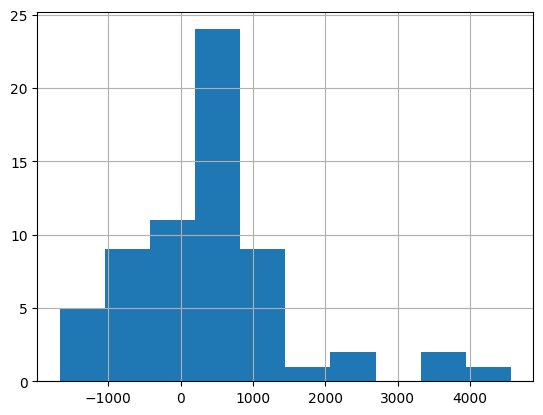

In [15]:
delta = mean_spends['treatment'] - mean_spends['control']
delta.hist()

In [14]:
delta.median()

np.float64(316.3674798262633)

In [16]:
delta[delta < 0].shape[0] / len(delta)

0.328125

In [19]:
df['catastrophic'] = df['hspend'] > 25_000
catas = df.groupby(
    ['cohort_id', 'treatment']
).apply(lambda x: (x['catastrophic'] * x['multiplier']).sum() / x['multiplier'].sum()).unstack()
catas

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_7642/91768787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['catastrophic'] = df['hspend'] > 25_000
/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_7642/91768787.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: (x['catastrophic'] * x['multiplier']).sum() / x['multiplier'].sum()).unstack()


treatment,False,True
cohort_id,,
81,0.000000,0.0
100,0.000000,0.0
126,0.016824,0.0
288,0.018916,0.0
290,0.000000,0.0
...,...,...
4603,0.000000,0.0
4605,0.000000,0.0
4618,0.000000,0.0


In [20]:
cat_delta = catas[True] - catas[False]
cat_delta

cohort_id
81      0.000000
100     0.000000
126    -0.016824
288    -0.018916
290     0.000000
          ...   
4603    0.000000
4605    0.000000
4618    0.000000
4936    0.000000
5453    0.000000
Length: 64, dtype: float64

In [21]:
cat_delta.median()

np.float64(0.0)

In [22]:
cat_delta[cat_delta < 0].shape[0] / len(cat_delta)

0.078125

In [ ]:
# The B part - Among households with no hospitalisation, does simply having insurance change spending behaviour?

In [2]:
health = health.loc[cohorts.index]
nohosp = health[health['is_hospitalization'] == 4]
nohosp = pd.concat([nohosp, cons.loc[nohosp.index], mult.loc[nohosp.index], cohorts.loc[nohosp.index, 'cohort_id']], axis=1, verify_integrity=True)
nohosp.head()

,is_hhmem_pmjay,is_hospitalization,is_benefit_healthscheme,71,72,140,141,142,143,144,...,97,99,432,630,631,632,633,639,multiplier,cohort_id
hhid,,,,,,,,,,,,,,,,,,,,,
46626303,1,4,NaN,NaN,NaN,60.0,NaN,NaN,60.0,120.0,...,NaN,1200.0,1200.0,NaN,NaN,NaN,NaN,NaN,141124,81
46626304,1,4,NaN,NaN,NaN,100.0,NaN,60.0,120.0,60.0,...,NaN,1500.0,1500.0,NaN,2000.0,NaN,NaN,2000.0,141124,81
46626307,1,4,NaN,NaN,NaN,NaN,60.0,NaN,60.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141124,79
46626310,1,4,NaN,NaN,NaN,100.0,NaN,NaN,60.0,NaN,...,NaN,400.0,400.0,1000.0,NaN,NaN,NaN,1000.0,141124,79
46626315,1,4,NaN,NaN,NaN,50.0,60.0,NaN,60.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141124,81


In [4]:
nohosp['treatment'] = nohosp['is_hhmem_pmjay'] == 1

In [5]:
nohosp.shape

(149070, 447)

In [6]:
nohosp['treatment'].value_counts()

treatment
False    100942
True      48128
Name: count, dtype: int64

In [9]:
counts = nohosp.groupby('cohort_id')['treatment'].value_counts().unstack()

In [16]:
counts.min(axis=0)

treatment
False    3.0
True     1.0
dtype: float64

In [52]:
large = counts[counts.fillna(0).min(axis=1) >= 20]

In [53]:
df = nohosp[nohosp['cohort_id'].isin(large.index)]

In [54]:
df.head()

,is_hhmem_pmjay,is_hospitalization,is_benefit_healthscheme,71,72,140,141,142,143,144,...,99,432,630,631,632,633,639,multiplier,cohort_id,treatment
hhid,,,,,,,,,,,,,,,,,,,,,
46626303,1,4,NaN,NaN,NaN,60.0,NaN,NaN,60.0,120.0,...,1200.0,1200.0,NaN,NaN,NaN,NaN,NaN,141124,81,True
46626304,1,4,NaN,NaN,NaN,100.0,NaN,60.0,120.0,60.0,...,1500.0,1500.0,NaN,2000.0,NaN,NaN,2000.0,141124,81,True
46626307,1,4,NaN,NaN,NaN,NaN,60.0,NaN,60.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141124,79,True
46626310,1,4,NaN,NaN,NaN,100.0,NaN,NaN,60.0,NaN,...,400.0,400.0,1000.0,NaN,NaN,NaN,1000.0,141124,79,True
46626315,1,4,NaN,NaN,NaN,50.0,60.0,NaN,60.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141124,81,True


In [55]:
for k, v in ITEM_CODES.items():
    if not k.startswith('HEALTH_'):
        if k == "FOOD":
            freq_mult, codes = np.array(v).T
            df[k] = (df[codes] * freq_mult.reshape(1, -1)).sum(axis=1) / 12
        elif k == "UTILITIES":
            df[k] = df[v].sum(axis=1)
        else:
            df[k] = df[v].sum(axis=1) / 12        

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_8030/1698536078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = (df[codes] * freq_mult.reshape(1, -1)).sum(axis=1) / 12
/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_8030/1698536078.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = df[v].sum(axis=1) / 12
/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_8030/1698536078.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [56]:
def get_basket(x):
    s = {}
    for k in ITEM_CODES:
        if not k.startswith('HEALTH_'):
            s[k] = (x[k] * x['multiplier']).sum() / x['multiplier'].sum()
    return pd.Series(s)

baskets = df.groupby(['cohort_id', 'treatment']).apply(get_basket)

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_8030/2650221230.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baskets = df.groupby(['cohort_id', 'treatment']).apply(get_basket)


In [57]:
baskets

FOOD       ASSETS    EDUCATION    UTILITIES
cohort_id treatment                                                     
79        False      20292.362241  1594.269319   998.923155  1836.359950
          True        8874.373760   589.417948   822.280172  1713.371743
81        False      24805.114467  1515.441195   977.160773  2087.325963
          True       12151.283512  1090.795759   727.194776  1938.500910
99        False       7258.213202  1328.556914   701.666705  1232.258355
...                           ...          ...          ...          ...
5988      True       11608.334530  1200.401095   774.199731   961.699288
5996      False       6936.197667   562.819513  1230.623996    98.088814
          True        6217.562352   314.810405  1633.418780   139.614661
5997      False       6026.469210  1318.208954   106.092805   573.060979
          True        3519.216346   229.979549   603.364909   195.456588

[970 rows x 4 columns]

In [64]:
tdf = baskets.xs(True, level=1)
cdf = baskets.xs(False, level=1)

In [68]:
deltas = tdf - cdf

In [71]:
(deltas > 0).sum(axis = 0) / len(deltas)

FOOD         0.358763
ASSETS       0.461856
EDUCATION    0.478351
UTILITIES    0.369072
dtype: float64

array([[<Axes: title={'center': 'FOOD'}>,
        <Axes: title={'center': 'ASSETS'}>],
       [<Axes: title={'center': 'EDUCATION'}>,
        <Axes: title={'center': 'UTILITIES'}>]], dtype=object)

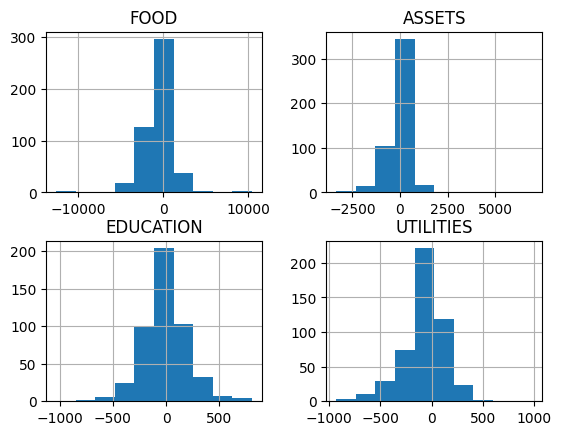

In [75]:
deltas.hist()

In [77]:
health = health.loc[cohorts.index]

In [78]:
intoxicants =   yaml.safe_load("""
  - 300
  - 301
  - 302
  - 310
  - 311
  - 316
  - 312
  - 314
  - 315
  - 313
  - 317
  - 322
  - 324
  - 323
  - 321
  - 320
  - 325""")

In [80]:
df = pd.concat([health, cons.loc[health.index], mult.loc[health.index], cohorts.loc[health.index, 'cohort_id']], axis=1, verify_integrity=True)
df.head()

,is_hhmem_pmjay,is_hospitalization,is_benefit_healthscheme,71,72,140,141,142,143,144,...,97,99,432,630,631,632,633,639,multiplier,cohort_id
hhid,,,,,,,,,,,,,,,,,,,,,
46626302,1,1,2.0,NaN,NaN,50.0,60.0,NaN,60.0,120.0,...,NaN,1500.0,1500.0,NaN,NaN,NaN,NaN,NaN,141124,81
46626303,1,4,NaN,NaN,NaN,60.0,NaN,NaN,60.0,120.0,...,NaN,1200.0,1200.0,NaN,NaN,NaN,NaN,NaN,141124,81
46626304,1,4,NaN,NaN,NaN,100.0,NaN,60.0,120.0,60.0,...,NaN,1500.0,1500.0,NaN,2000.0,NaN,NaN,2000.0,141124,81
46626305,1,2,1.0,NaN,NaN,NaN,60.0,NaN,120.0,NaN,...,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,1000.0,141124,81
46626307,1,4,NaN,NaN,NaN,NaN,60.0,NaN,60.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141124,79


In [81]:
df["INTOX"] = df[intoxicants].sum(axis=1)

<Axes: >

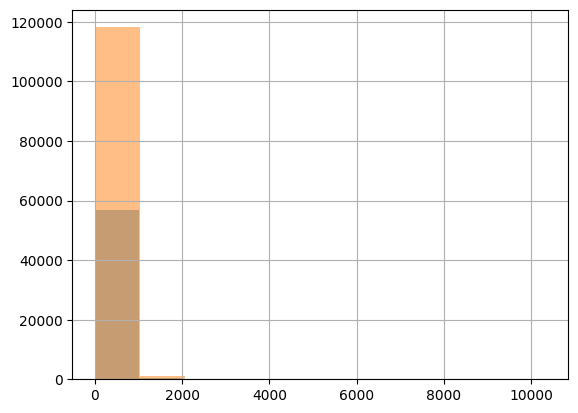

In [85]:
ax = df[df['is_hhmem_pmjay'] == 1]['INTOX'].hist(alpha=0.5)
df[df['is_hhmem_pmjay'] != 1]['INTOX'].hist(alpha=0.5, ax=ax)